In [ ]:
from src.model import get_llamaindex_model, get_llamaindex_model_mini, get_huggingface_embedding_model
from llama_index.core import Settings

llm = get_llamaindex_model_mini()

llm2 = get_llamaindex_model()

embed_model = get_huggingface_embedding_model()
Settings.embed_model = embed_model
Settings.llm = llm2

C:\Users\newac\OneDrive\Desktop\Master\final_structure\src\__init__.py:16: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from .DAG_creator import build_rag_workflow


In [ ]:
from src.parser import markdownParser
nodes = markdownParser(input_dir="../kgdata/")
print(f"Processed {len(nodes)} nodes.")
if nodes:
    print("First node text:", nodes[1].text)

Processed 945 nodes.
First node text: ## criteria
- critical | unconscious adult, not breathing normally


In [3]:
nodes[1].metadata

{'file_path': '01.md',
 'file_name': '01.md',
 'file_size': 8702,
 'creation_date': '2025-04-21',
 'last_modified_date': '2025-04-21',
 'header_path': '/01 Unconscious adult – not breathing normally/CRITERIA'}

In [ ]:
from src.retriever import create_retriever

docs  = create_retriever(nodes, llm=llm, type="hybrid", extractor="Custom", max_nodes=10)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# faiss_index = a.client  # or index.vector_store._faiss_index
# embeddings = [faiss_index.reconstruct(i) for i in range(faiss_index.ntotal)]
# embeddings

In [ ]:
# vector_retriever = vec_rev.as_retriever(similarity_top_k=10)
# kg_retriever = kg_index.as_retriever(similarity_top_k=10)

# vector_results = vector_retriever.retrieve("help me revive a unconcious person")
# kg_results = kg_retriever.retrieve("help me revive a unconcious person")
# print("Vector Store Results:")
# for node in vector_results:
#     print(node.metadata)
#     node.metadata['source'] = 'vector'
#     print(node.metadata)
# print("\nKnowledge Graph Results:")
# for node in kg_results:
#     print(node)

INFO:httpx:HTTP Request: POST https://d-ais-eus-ais-chatbots.openai.azure.com/openai/deployments/o1-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"


Vector Store Results:
{'file_path': 'c:\\Users\\newac\\OneDrive\\Desktop\\Master\\final_structure\\..\\kgdata\\01.md', 'file_name': '01.md', 'file_size': 8702, 'creation_date': '2025-04-21', 'last_modified_date': '2025-04-21', 'header_path': '/01 Unconscious adult – not breathing normally/EMERGENCY RESPONSE/IF YES'}
{'file_path': 'c:\\Users\\newac\\OneDrive\\Desktop\\Master\\final_structure\\..\\kgdata\\01.md', 'file_name': '01.md', 'file_size': 8702, 'creation_date': '2025-04-21', 'last_modified_date': '2025-04-21', 'header_path': '/01 Unconscious adult – not breathing normally/EMERGENCY RESPONSE/IF YES', 'source': 'vector'}
{'file_path': 'c:\\Users\\newac\\OneDrive\\Desktop\\Master\\final_structure\\..\\kgdata\\01.md', 'file_name': '01.md', 'file_size': 8702, 'creation_date': '2025-04-21', 'last_modified_date': '2025-04-21', 'header_path': '/01 Unconscious adult – not breathing normally/EMERGENCY RESPONSE/IF NO'}
{'file_path': 'c:\\Users\\newac\\OneDrive\\Desktop\\Master\\final_struc

In [2]:
from typing import Dict, Any, List, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.documents import Document
import logging


In [3]:
RETREIVER_TYPE = "hybrid"

In [19]:
from src import get_azure_openai_model, get_azure_openai_chat_model, get_azure_openai_mini_model

model = get_azure_openai_chat_model()
model_mini = get_azure_openai_mini_model()

In [20]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
import json
from typing import List, Optional, Dict, Any
from langgraph.graph import END, StateGraph, START
from typing_extensions import TypedDict


In [21]:
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""
    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

In [22]:
# =============================================================================
# STATE DEFINITION
# =============================================================================

class GraphState(TypedDict):
    """
    Represents the state of our graph.
    
    Attributes:
        question: The original user question
        documents: List of retrieved documents
        generation: Generated answer
        grade: Grade of document relevance
        iterations: Number of iterations for rephrasing
        rephrased_question: Rephrased version of the question
    """
    question: str
    documents: List[Document]
    generation: str
    grade: str
    iterations: int
    rephrased_question: str
    llm: str
    

    

In [ ]:
##### TODO: Seperate the retriverals from here
from src.retriever import create_retriever



In [36]:
def retrieve(state: GraphState) -> Dict[str, Any]:
    """
    Retrieve documents based on the question.
    
    Args:
        state: The current graph state
        
    Returns:
        Updated state with retrieved documents
    """
    print("--- RETRIEVE ---")
    
    # Use rephrased question if available, otherwise use original
    question = state.get("rephrased_question", state["question"])

    if state.get("rephrased_question"):
        print(f"Using rephrased question: {question}")
    else:
        print(f"Using original question: {question}")
    
    # if RETREIVER_TYPE == "hybrid":
    #     print("Using hybrid retriever")
    #     vec_index, kg_index, a,b =create_retriever(nodes, llm=llm, type="hybrid", extractor="Custom", max_nodes=10, load_persist="./kg_index_storage_v1/pg_store_v2_custom.json")
    #     vector_retriever = vec_index.as_retriever(similarity_top_k=2)
    #     kg_retriever = kg_index.as_retriever(similarity_top_k=2)
    #     # Retrieve documents from both vector and knowledge graph retrievers
    #     vec_documents = vector_retriever.retrieve(question)
    #     kg_documents = kg_retriever.retrieve(question)

    #     # Adding metadata to distinguish sources
    #     for doc in vec_documents:
    #         doc.metadata['source'] = 'vector'
    #     for doc in kg_documents:
    #         doc.metadata['source'] = 'knowledge_graph'

    #     documents = vec_documents + kg_documents[:2]  # Limit KG results to 10 for performance
    #     print(f"Retrieved {len(documents)} documents from hybrid retriever. Vector: {len(vec_documents)}, KG: {len(kg_documents)}")
        
    # elif RETREIVER_TYPE == "vector":
    #     print("Using vector retriever")
    #     vec_index, kg_index, a,b =create_retriever(nodes, llm=llm, type="vector_store", extractor="Custom", max_nodes=10)
    #     vector_retriever = vec_index.as_retriever(similarity_top_k=10)
    #     kg_retriever = None

    #     documents = vector_retriever.retrieve(question)
    #     for doc in documents:
    #         doc.metadata['source'] = 'vector'
    # elif RETREIVER_TYPE == "kg":
    #     print("Using knowledge graph retriever")
    #     vec_index, kg_index, a,b =create_retriever(nodes, llm=llm, type="knowledge_graph", extractor="Custom", max_nodes=10, persist_path="final_structure\kg_index_storage_v1\pg_store_v2_custom.json")
    #     vector_retriever = None
    #     kg_retriever = kg_index.as_retriever(similarity_top_k=10)

    #     documents = kg_retriever.retrieve(question)
    #     for doc in documents:
    #         doc.metadata['source'] = 'knowledge_graph'
        
    # else:
    #     raise ValueError(f"Unknown retriever type: {RETREIVER_TYPE}, define global variable RETREIVER_TYPE as 'hybrid', 'vector', or 'kg'")
    documents = create_retriever(question, llm=model, extractor="Custom", max_nodes=10, load_persist="./kg_index_storage_v1/pg_store_v2_custom.json")
    print(f"Retrieved {len(documents)} documents")
    
    return {
        "documents": documents,
        "question": state["question"],
        "rephrased_question": state.get("rephrased_question", ""),
        "iterations": state.get("iterations", 0),
        "generation": state.get("generation", ""),
        "grade": state.get("grade", "")
    }

In [25]:
def grade_documents(state: GraphState) -> Dict[str, Any]:
    """
    Determines whether the retrieved documents are relevant to the question.
    
    Args:
        state: The current graph state
        
    Returns:
        Updated state with document relevance grade
    """
    print("--- CHECK DOCUMENT RELEVANCE TO QUESTION ---")
    
    question = state["question"]
    documents = state["documents"]
    
    # Grading prompt
    grade_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a grader assessing relevance of a retrieved document to a user question.
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
        Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the question.
        Provide the binary score as a JSON with a single key 'score' and no preamble or explanation."""),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}")
    ])
    
    # Grade each document
    relevant_docs = []
    for doc in documents:
        grade_chain = grade_prompt | model | StrOutputParser()
        grade = grade_chain.invoke({"question": question, "document": doc.text})
        
        try:
            grade_dict = json.loads(grade)
            if grade_dict.get("score", "").lower() == "yes":
                relevant_docs.append(doc)
                print(f"--- GRADE: DOCUMENT RELEVANT ---")
            else:
                print(f"--- GRADE: DOCUMENT NOT RELEVANT ---")
        except json.JSONDecodeError:
            # If JSON parsing fails, assume relevant to be safe
            relevant_docs.append(doc)
            print(f"--- GRADE: DOCUMENT RELEVANT (JSON parse failed) ---")
    
    # Determine overall grade
    if relevant_docs:
        grade = "relevant"
        # documents_to_use = relevant_docs
    else:
        grade = "not_relevant"
        # documents_to_use = documents  # Keep all documents if none are graded as relevant
        
    
    return {
        "documents": relevant_docs,
        "question": state["question"],
        "rephrased_question": state.get("rephrased_question", ""),
        "iterations": state.get("iterations", 0),
        "generation": state.get("generation", ""),
        "grade": grade
    }

In [26]:
def generate(state: GraphState) -> Dict[str, Any]:
    """
    Generate answer using the retrieved documents.
    
    Args:
        state: The current graph state
        
    Returns:
        Updated state with generated answer
    """
    print("--- GENERATE ---")
    
    question = state["question"]
    documents = state["documents"]
    
    # Create context from documents
    context = "\n\n".join([doc.text for doc in documents])
    
    # Generation prompt
    generate_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an assistant for question-answering tasks.
        Use the following pieces of retrieved context to answer the question.
        If you don't know the answer, just say that you don't know.
        
        Do not make up answers or provide information not present in the context.
         
         Say 'I don't know' if you cannot find an answer in the context.
        If the question is not answerable with the provided context, say 'I don't know'.
        
        Context: {context}"""),
        ("human", "{question}")
    ])
    
    # Generate answer
    generate_chain = generate_prompt | model | StrOutputParser()
    generation = generate_chain.invoke({"context": context, "question": question})
    
    print(f"Generated answer: {generation[:100]}...")
    
    return {
        "documents": state["documents"],
        "question": state["question"],
        "rephrased_question": state.get("rephrased_question", ""),
        "iterations": state.get("iterations", 0),
        "generation": generation,
        "grade": state.get("grade", "")
    }


In [27]:
def transform_query(state: GraphState) -> Dict[str, Any]:
    """
    Transform the query to produce a better question for retrieval.
    
    Args:
        state: The current graph state
        
    Returns:
        Updated state with rephrased question
    """
    print("--- TRANSFORM QUERY ---")
    
    question = state["question"]
    iterations = state.get("iterations", 0)
    
    # Query transformation prompt
    transform_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are generating questions that are well optimized for retrieval.
        Look at the input and try to reason about the underlying semantic intent / meaning.
        Here is the initial question:
        \n ------- \n
        {question} 
        \n ------- \n
        Formulate an improved question that will be more effective for document retrieval."""),
        ("human", "Provide the improved question:")
    ])
    
    # Transform query
    transform_chain = transform_prompt | model | StrOutputParser()
    rephrased_question = transform_chain.invoke({"question": question})
    
    print(f"Rephrased question: {rephrased_question}")
    
    return {
        "documents": state.get("documents", []),
        "question": state["question"],
        "rephrased_question": rephrased_question,
        "iterations": iterations + 1,
        "generation": state.get("generation", ""),
        "grade": state.get("grade", "")
    }


In [28]:
def grade_generation_v_documents_and_question(state: GraphState) -> str:
    """
    Determines whether the generation is grounded in the document and answers question.
    
    Args:
        state: The current graph state
        
    Returns:
        Next node to call
    """
    print("--- CHECK HALLUCINATIONS ---")
    
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    iterations = state.get("iterations", 0)
    
    # Hallucination grading prompt
    hallucination_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.
        Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts.
        Provide the binary score as a JSON with a single key 'score' and no preamble or explanation."""),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}")
    ])
    
    hallucination_chain = hallucination_prompt | model | StrOutputParser()
    grade = hallucination_chain.invoke({
        "documents": "\n\n".join([doc.text for doc in documents]),
        "generation": generation
    })
    
    try:
        grade_dict = json.loads(grade)
        grounded = grade_dict.get("score", "").lower() == "yes"
    except json.JSONDecodeError:
        grounded = True  # Assume grounded if parsing fails
    
    print(f"Grounded: {grounded}")
    
    # Check question answering
    print("--- GRADE GENERATION vs QUESTION ---")
    
    answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a grader assessing whether an answer addresses / resolves a question.
        Give a binary score 'yes' or 'no'. 'Yes' means that the answer resolves the question.
        Provide the binary score as a JSON with a single key 'score' and no preamble or explanation."""),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}")
    ])
    
    answer_chain = answer_prompt | model | StrOutputParser()
    grade = answer_chain.invoke({"question": question, "generation": generation})
    
    try:
        grade_dict = json.loads(grade)
        useful = grade_dict.get("score", "").lower() == "yes"
    except json.JSONDecodeError:
        useful = True  
    
    print(f"Useful: {useful}")

    # Add safety check for max iterations
    if iterations >= 1:
        print("--- MAX ITERATIONS REACHED, ENDING ---")
        return END
    
    if grounded and useful:
        print("--- DECISION: GENERATION IS GROUNDED AND USEFUL ---")
        return "Useful"  # Use END instead of "Useful"
    elif not grounded:
        print("--- DECISION: GENERATION IS NOT GROUNDED, RE-GENERATE ---")
        return "generate" 
    else:
        print("--- DECISION: GENERATION IS NOT USEFUL, TRANSFORM QUERY ---")
        return "transform_query"
    

In [29]:
def decide_to_generate(state: GraphState) -> str:
    """
    Determines whether to generate an answer or re-generate a question.
    
    Args:
        state: The current graph state
        
    Returns:
        Next node to call
    """
    print("--- ASSESS GRADED DOCUMENTS ---")
    
    grade = state["grade"]
    documents = state["documents"]
    
    print(f"Grade: {grade}, Number of documents: {len(documents)}")
    
    # if grade == "relevant":
    if len(documents) > 5:
        print("--- DECISION: DOCUMENTS ARE RELEVANT, GENERATE ANSWER ---")
        return "generate"
    else:
        print("--- DECISION: DOCUMENTS ARE NOT RELEVANT, TRANSFORM QUERY ---")
        return "transform_query"

In [30]:
def max_iterations_check(state: GraphState) -> str:
    """
    Check if maximum iterations reached to prevent infinite loops.
    
    Args:
        state: The current graph state
        
    Returns:
        Next node to call
    """
    max_iterations = 1
    iterations = state.get("iterations", 0)
    
    if iterations >= max_iterations:
        print(f"--- MAX ITERATIONS ({max_iterations}) REACHED ---")
        return "generate"
    else:
        return "retrieve"

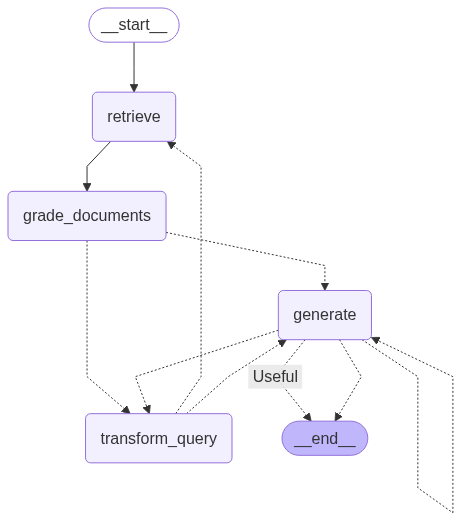

In [37]:
# Build the graph
graphA = StateGraph(GraphState)
# graph.add_node(START, "retrieve")
graphA.add_node("retrieve", retrieve)
# graphA.add_node("generate", generate)
graphA.add_node("grade_documents", grade_documents)
graphA.add_node("generate", generate)
graphA.add_node("transform_query", transform_query)

# # Add edges (transitions)
graphA.add_edge(START, "retrieve")
graphA.add_edge("retrieve", "grade_documents")
graphA.add_conditional_edges("grade_documents", decide_to_generate, 
                            {
                                "generate": "generate",
                                "transform_query": "transform_query"
                            })
graphA.add_conditional_edges(
        "transform_query",
        max_iterations_check,
        {
            "retrieve": "retrieve",
            "generate": "generate"
        }
    )
graphA.add_conditional_edges(
        "generate",
        grade_generation_v_documents_and_question,
        {
            "Useful": END,
            END: END,
            "transform_query": "transform_query",
            "generate": "generate"
        }
    )
# graphA.add_edge("generate", "retrieve")
# graphA.add_edge("grade_documents", END)
# graphA.add_edge("retrieve", "grade_documents")
# graphA.add_conditional_edges("grade_documents", decide_generation, "generate")
# graphA.add_edge("generate", END)


# Compile the graph
graph_runnable = graphA.compile()

from IPython.display import Image, display

try:
    display(Image(graph_runnable.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [38]:
inputs = {"question": "harry potter and the philosopher's stone summary",}
for output in graph_runnable.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

# Final generation
# Will be in the last node
print(value["documents"])
print(value["grade"])

--- RETRIEVE ---
Using original question: harry potter and the philosopher's stone summary


TypeError: 'NoneType' object is not subscriptable

In [ ]:
value["generation"]

"I don't know."

In [ ]:
# using the DAG
from src.DAG_creator import build_rag_workflow
question= "how to revive a person who is unconscious"

app = build_rag_workflow()

# Initial state
inputs = {
    "question": question,
    "llm": model,
    "retriever_type": RETREIVER_TYPE,
    "load_persist": "./kg_index_storage_v1/pg_store_v2_custom.json",
}

# Run the workflow
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

# Final generation
# Will be in the last node
print(value["documents"])
print(value["grade"])

--- RETRIEVE ---
Using original question: how to revive a person who is unconscious


TypeError: 'NoneType' object is not subscriptable